In [1]:
!pip install mnist

In [0]:
import numpy as np
import cv2
import random
import occlusion_cnn
import matplotlib.pyplot as plt
from PIL import Image
import mnist
random.seed(1)
np.random.seed(1)

In [3]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = mnist.train_images()
y_train = mnist.train_labels()
x_test = mnist.test_images()
y_test = mnist.test_labels()

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
hdm = occlusion_cnn.HausdorffDistanceMasks(28, 28)
hdm.generate_masks(1, 1)

In [0]:
def evaluate(weight):
  model.load_weights(weight)
  for index in [9953, 3850, 4962, 3886, 5437, 8517, 2041, 1989, 1933, 9984]:
      image = x_test[index]

      label = np.argmax(y_test[index])
      print('label:', label)

      baseline = model.predict(image.reshape(1, 28, 28, 1))

      print('prediction', np.argmax(baseline[0]))

      result = hdm.explain(model, image.reshape(28, 28), baseline[0], output_class=label)

      plt.imshow(image.reshape(28, 28), cmap='Greys_r')
      plt.show()

      img = plt.imshow(result.distances(occlusion_cnn.RAW))
      plt.colorbar(img)
      plt.show()

label: 6
prediction 6


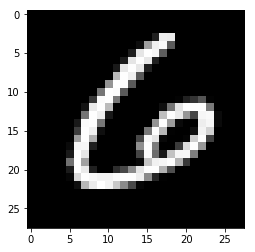

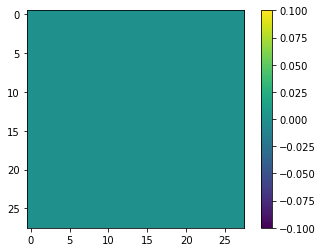

label: 9
prediction 4


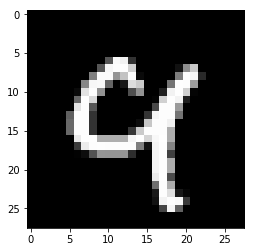

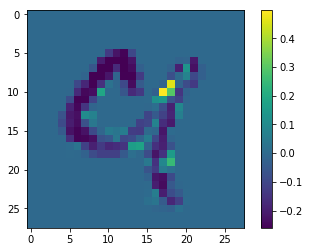

label: 2
prediction 2


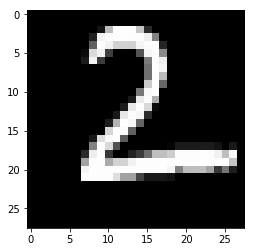

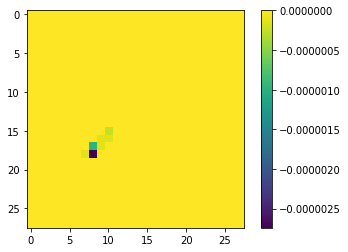

label: 6
prediction 6


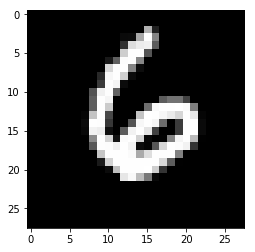

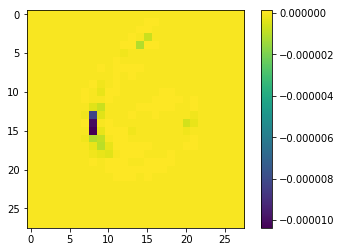

label: 7
prediction 7


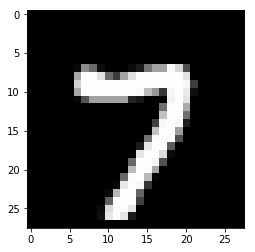

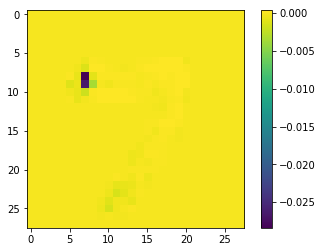

label: 6
prediction 6


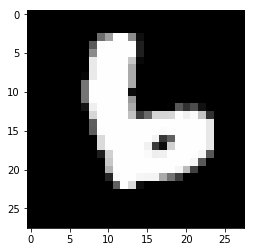

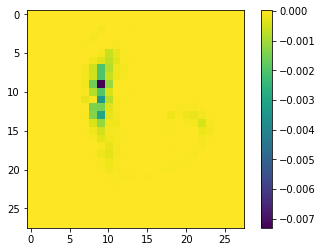

label: 1
prediction 1


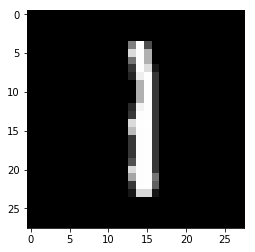

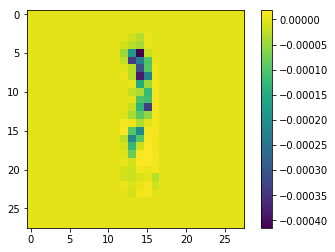

label: 4
prediction 4


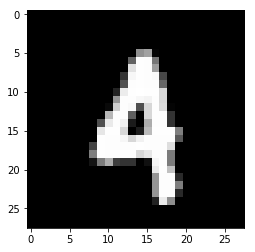

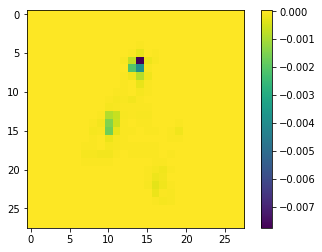

label: 7
prediction 7


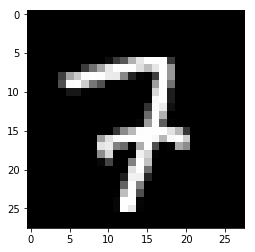

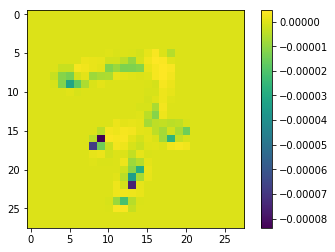

label: 1
prediction 1


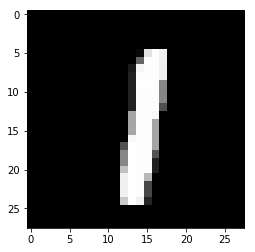

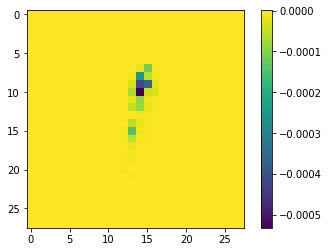

In [7]:
evaluate('weights-07-0.9625-0.9904.hdf5')

label: 6
prediction 6


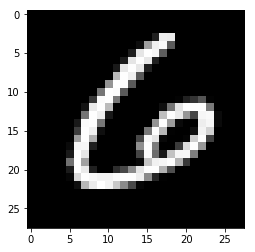

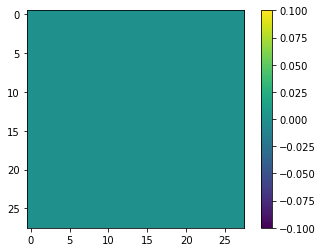

label: 9
prediction 9


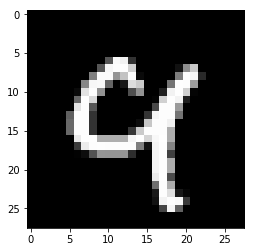

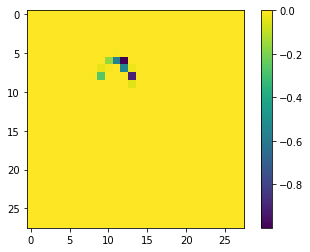

label: 2
prediction 2


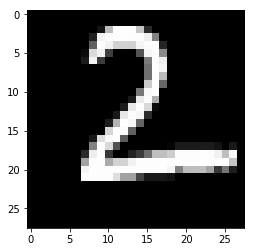

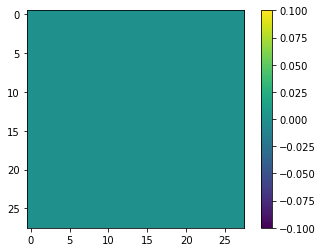

label: 6
prediction 6


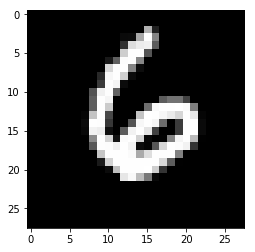

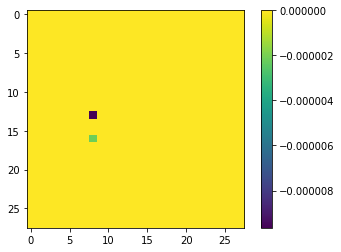

label: 7
prediction 7


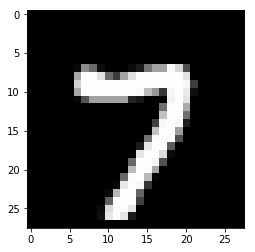

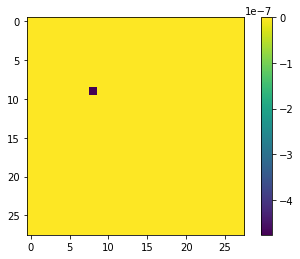

label: 6
prediction 6


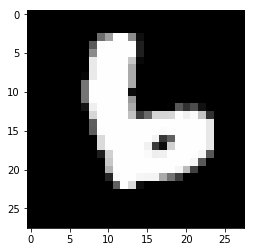

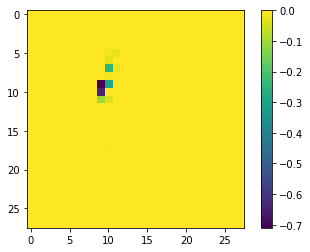

label: 1
prediction 1


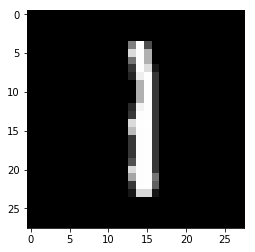

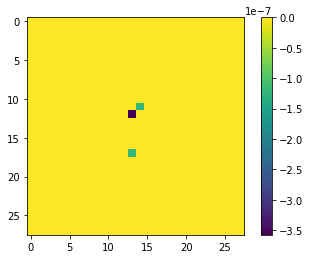

label: 4
prediction 4


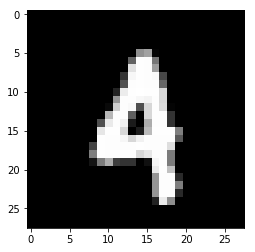

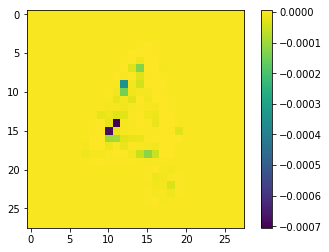

label: 7
prediction 7


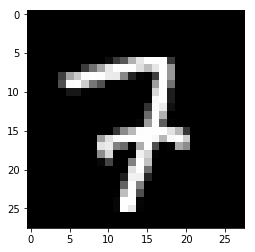

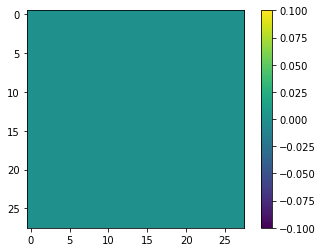

label: 1
prediction 1


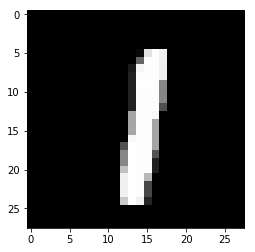

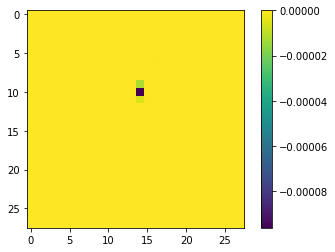

In [8]:
evaluate('weights-72-0.9744-0.9918.hdf5')

In [0]:
import os
import numpy as np
from skimage.transform import resize

MASK_PATH = os.path.join('rise_masks.npy')

#MASK_COUNT = 500
#s = 8
#p1 = 0.5

MASK_COUNT = 5000
s = 8
p1 = 0.5

def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks


def explain(model, inp, masks, input_size):
    batch_size = 100
    preds = []
    # Make sure multiplication is being done for correct axes

    for i in range(0, MASK_COUNT, batch_size):
        #print(i, MASK_COUNT)
        sub_masks = masks[i:min(i + batch_size, MASK_COUNT)]
        masked = inp * sub_masks
        preds.append(model.predict(masked))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(MASK_COUNT, -1)).reshape(-1, *input_size)
    sal = sal / MASK_COUNT / p1
    return sal



masks = generate_masks(MASK_COUNT, s, p1, (28, 28))

In [0]:
def evaluate_rise(weight):
  model.load_weights(weight)
  for index in [9953, 3850, 4962, 3886, 5437, 8517, 2041, 1989, 1933, 9984]:
      image = x_test[index]

      label = np.argmax(y_test[index])
      print('label:', label)

      baseline = model.predict(image.reshape(1, 28, 28, 1))

      print('prediction', np.argmax(baseline[0]))

      sal = explain(model, image, masks, (28, 28))

      plt.imshow(image.reshape(28, 28), cmap='Greys_r')
      plt.show()

      img = plt.imshow(sal[label])
      plt.show()

label: 6
prediction 6


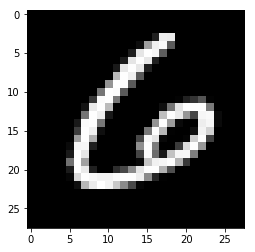

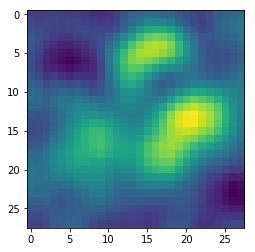

label: 9
prediction 4


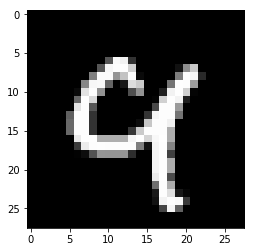

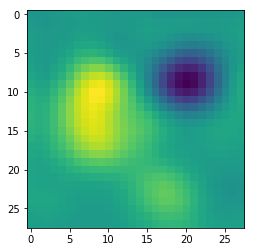

label: 2
prediction 2


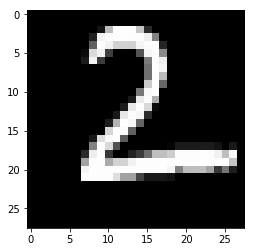

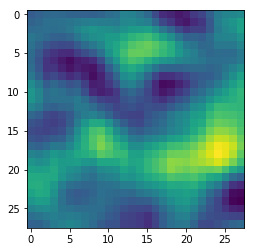

label: 6
prediction 6


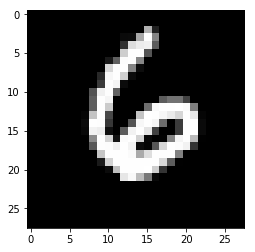

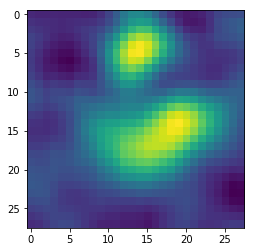

label: 7
prediction 7


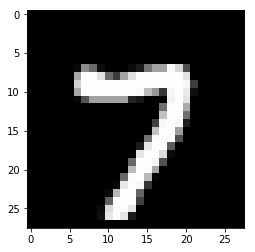

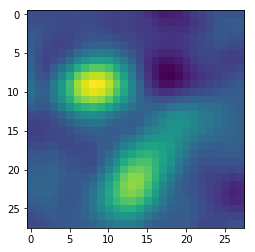

label: 6
prediction 6


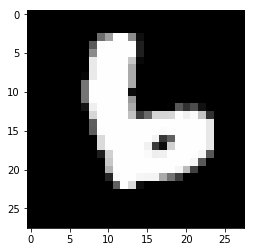

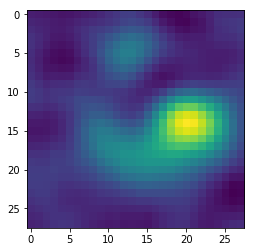

label: 1
prediction 1


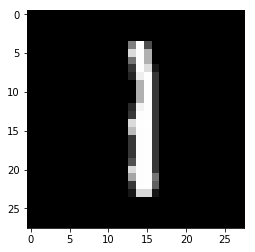

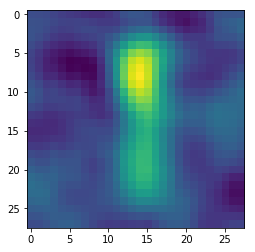

label: 4
prediction 4


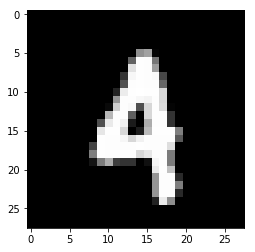

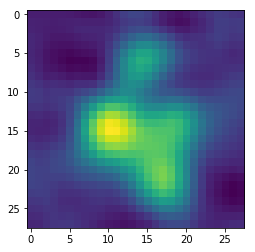

label: 7
prediction 7


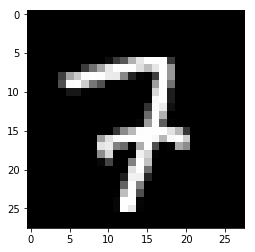

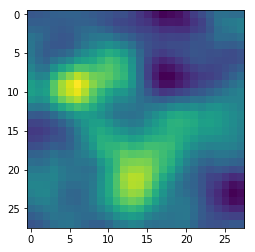

label: 1
prediction 1


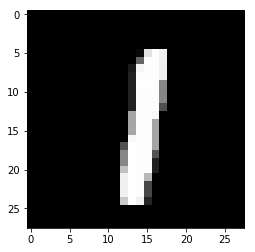

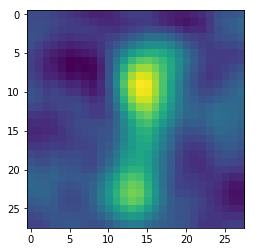

In [11]:
evaluate_rise('weights-07-0.9625-0.9904.hdf5')

label: 6
prediction 6


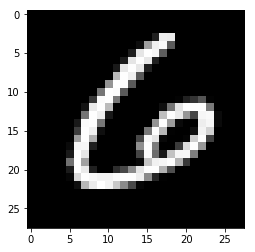

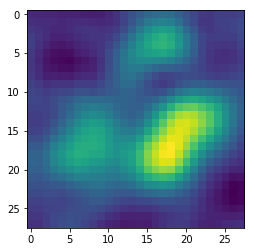

label: 9
prediction 9


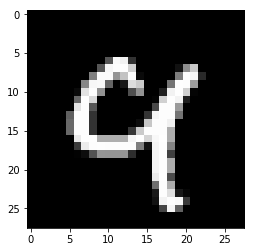

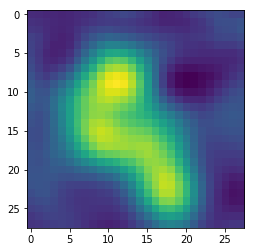

label: 2
prediction 2


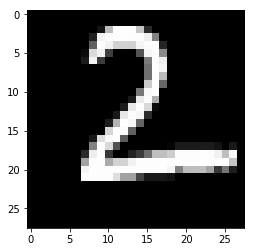

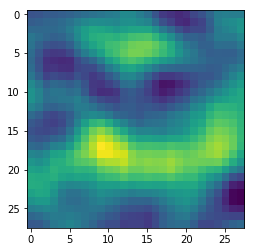

label: 6
prediction 6


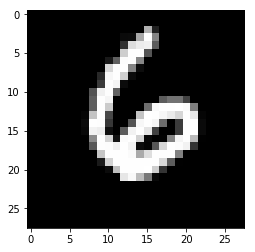

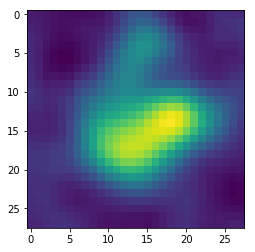

label: 7
prediction 7


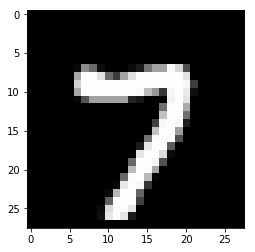

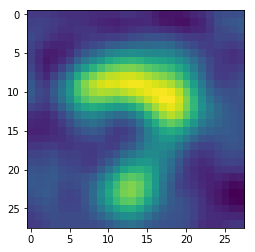

label: 6
prediction 6


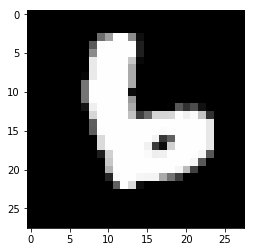

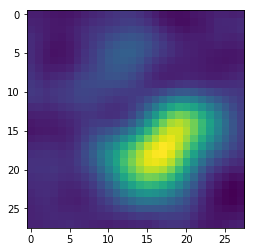

label: 1
prediction 1


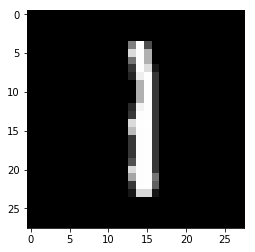

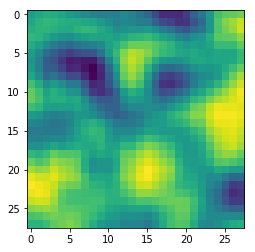

label: 4
prediction 4


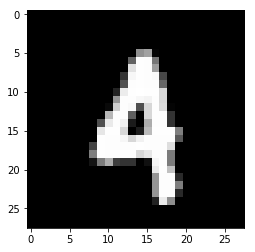

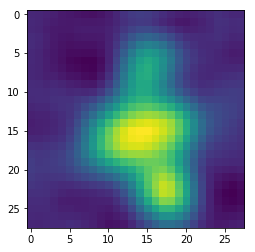

label: 7
prediction 7


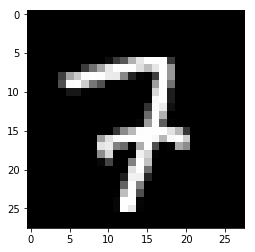

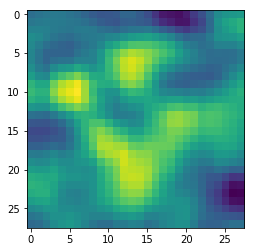

label: 1
prediction 1


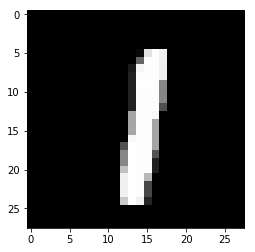

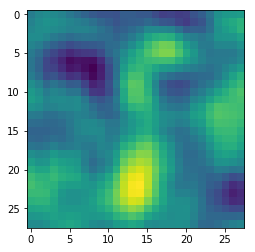

In [12]:
evaluate_rise('weights-72-0.9744-0.9918.hdf5')